In [1]:
%matplotlib inline
%load_ext line_profiler
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import numpy as np
from os.path import join
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
import colorcet as cc
from ipdb import set_trace
import pandas as pd
from p_tqdm import p_map, p_umap # parallel map
from tqdm.auto import tqdm, trange
from functools import partial
pmap = p_map
lmap = lambda f, L: list(map(f, L))

import PIL
from io import BytesIO
import PIL.Image
from tqdm.auto import tqdm
import umap
from sklearn.manifold import TSNE


from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from cifarclass import cifar100_classes

from pncommon import * # my stuff

rng = np.random.default_rng(2)

## Load Data

In [3]:
 import os
 os.system('hostname')

dshift-parser


0

In [4]:
name = "CIFAR100_test"
train_set = "CIFAR100_train"

label_mapping=cifar100_classes
classes = list(label_mapping.values())
NUM_SAMPLES = 10000
NUM_LABELS=100

print("loading data")
with open('./proc/jan1_proc.pk', 'rb') as file:
    grouped = pickle.load(file)

dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print('groups:', grouped.keys())
Gs = grouped

loading data
Files already downloaded and verified
groups: dict_keys(['ClipViTB32', 'ClipViTB16', 'Resnet18-pretrained', 'Densenet121-pretrained', 'Resnet18', 'Densenet121'])


In [25]:
gname='Resnet18'
G = Gs[gname]
t = 'probs' # 'freqs', 'probs', 'fsmooth'
P = G[t]
xkey = 'x' if t!='probs' else 'xsoft' #
xkey = 'x'
x = G[xkey]

def accuracy(i, prof):
    true_label = ytest[i]
    return prof[true_label]

def nonmono(i, prof, sigma=1.0):
    acc = accuracy(i, prof)
    acc = gaussian_filter1d(acc, sigma=sigma) # smooth it
    #np.max(acc.reshape(-1, 1)- acc.reshape(1, -1))
    d = acc[1:] - acc[:-1] # first derivative
    nm = np.sum(np.abs(d.clip(max=0))) # itegrate only negative part
    return nm

def thresh(i, prof, sigma=1.0): # score for large jumps
    acc = accuracy(i, prof)
    acc = gaussian_filter1d(acc, sigma=sigma) # smooth it
    #np.max(acc.reshape(-1, 1)- acc.reshape(1, -1))
    d = acc[1:] - acc[:-1] # first derivative
    nm = np.linalg.norm(d, ord=4) # 4-norm of derivative
    return nm
    
def easy(i,prof, sigma = 1.0):
    acc = accuracy(i,prof)
    acc = gaussian_filter1d(acc, sigma=sigma) # smooth it
    return np.mean(acc)

def hard(i,prof,sigma=1.0):
    return 1-easy(i,prof,sigma)

nonmono(0, G[t][0]), thresh(0,G[t][0]), easy(0,G[t][0])

(0.10656704009198943, 0.019074439085919003, 0.07688288188334512)

In [16]:
a = np.array([1,2,3])
# compute norm 2 of a


np.pow(a,2)

AttributeError: module 'numpy' has no attribute 'pow'

In [26]:
def get_scores(P,*funcs):
    D = {}
    for f in funcs:
        D[f.__name__] = np.array(lmap(lambda i: f(i, P[i]), trange(NUM_SAMPLES)))
    return D


scores = get_scores(P, nonmono,thresh, easy, hard)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

nonmono


AttributeError: 'Rectangle' object has no property 'title'

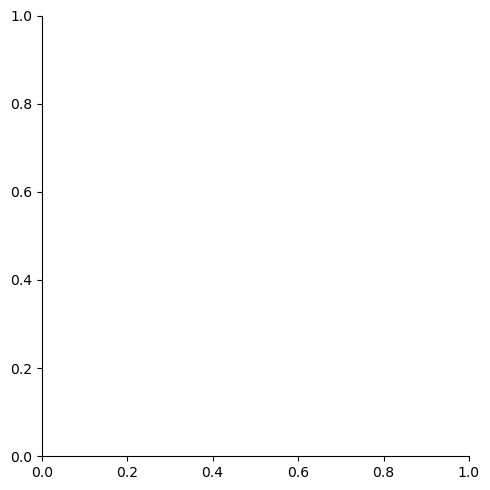

In [28]:
idxes = {} 
for k,s in scores.items():
    print(k)
    sns.displot(s);
    idxes[k] = np.argsort(-s)

# INDICES = np.flatnonzero(scores > 0.02)
# scores = scores[INDICES]
# sns.displot(scores)

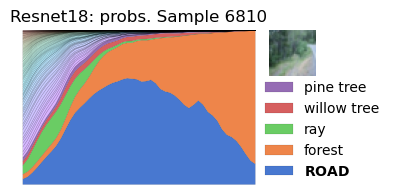

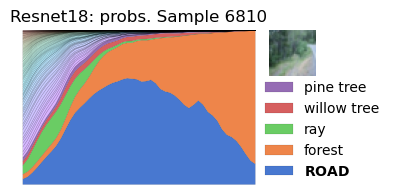

In [8]:
def stacksimple(i, x, prof, topk=5, ax=None):
    """
        i: index of image in dataset
        x: x-axis points
        prof: profile (NUM_LABELS, len(x))
        topk: number of "main" labels, for the legend.
    """
    true_label = ytest[i]
    areas = prof.sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals

    label_names = [classes[idx] if j < topk else '_nolegend_' for j, idx in enumerate(ind)]
    if ax is None:
        # f, ax = plt.subplots(figsize=(7, 5))
        f, ax = plt.subplots(figsize=(3, 2))
    
    colors = sns.color_palette('muted')[:topk] # first k colors: by palette
    cm = sns.color_palette('rainbow', as_cmap=True)
    fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    colors += [fix_alpha(cm(v)) for v in np.linspace(0, 1,len(ind)-topk)]
    
    stacks = ax.stackplot(x, prof[ind], labels=label_names, colors=colors)
    
    for s in stacks: #stacks[topk:]:
        s.set_edgecolor((0,0,0, 0.3))
        s.set_linewidth(0.2)
    
    handles, labels = ax.get_legend_handles_labels()
    labels[0] = "$\\bf{" + labels[0].upper().replace('_', '\ ') + "}$"
    labels = list(map(lambda e : e.replace('_', ' '), labels))
    handles, labels = handles[::-1], labels[::-1] # flip order
    
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 0), loc='lower left', borderaxespad=0, frameon=False)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, 1)
    ax.set_axis_off()  
    sns.despine()
    
    ax2 = ax.inset_axes([1.01, 0.7, 0.3, 0.3], aspect='equal')
    ax2.set_axis_off()
    ax2.imshow(dataset[i][0])
    
    return ax.figure


## generate plot
xkey = 'x' if t!='probs' else 'xsoft'
x = G[xkey]
# i = rng.choice(INDICES) # random image index
i=idx[0]
sns.reset_defaults()
mpl.rcParams['font.family'] = 'sans-serif'

yy = G[t][i]
for j in range(len(yy)):
    yy[j] = gaussian_filter1d(yy[j], sigma=1.0)
    
f = stacksimple(i, x, yy) # the actual plot
f.axes[0].set_title(f'{gname}: {t}. Sample {i}');
f

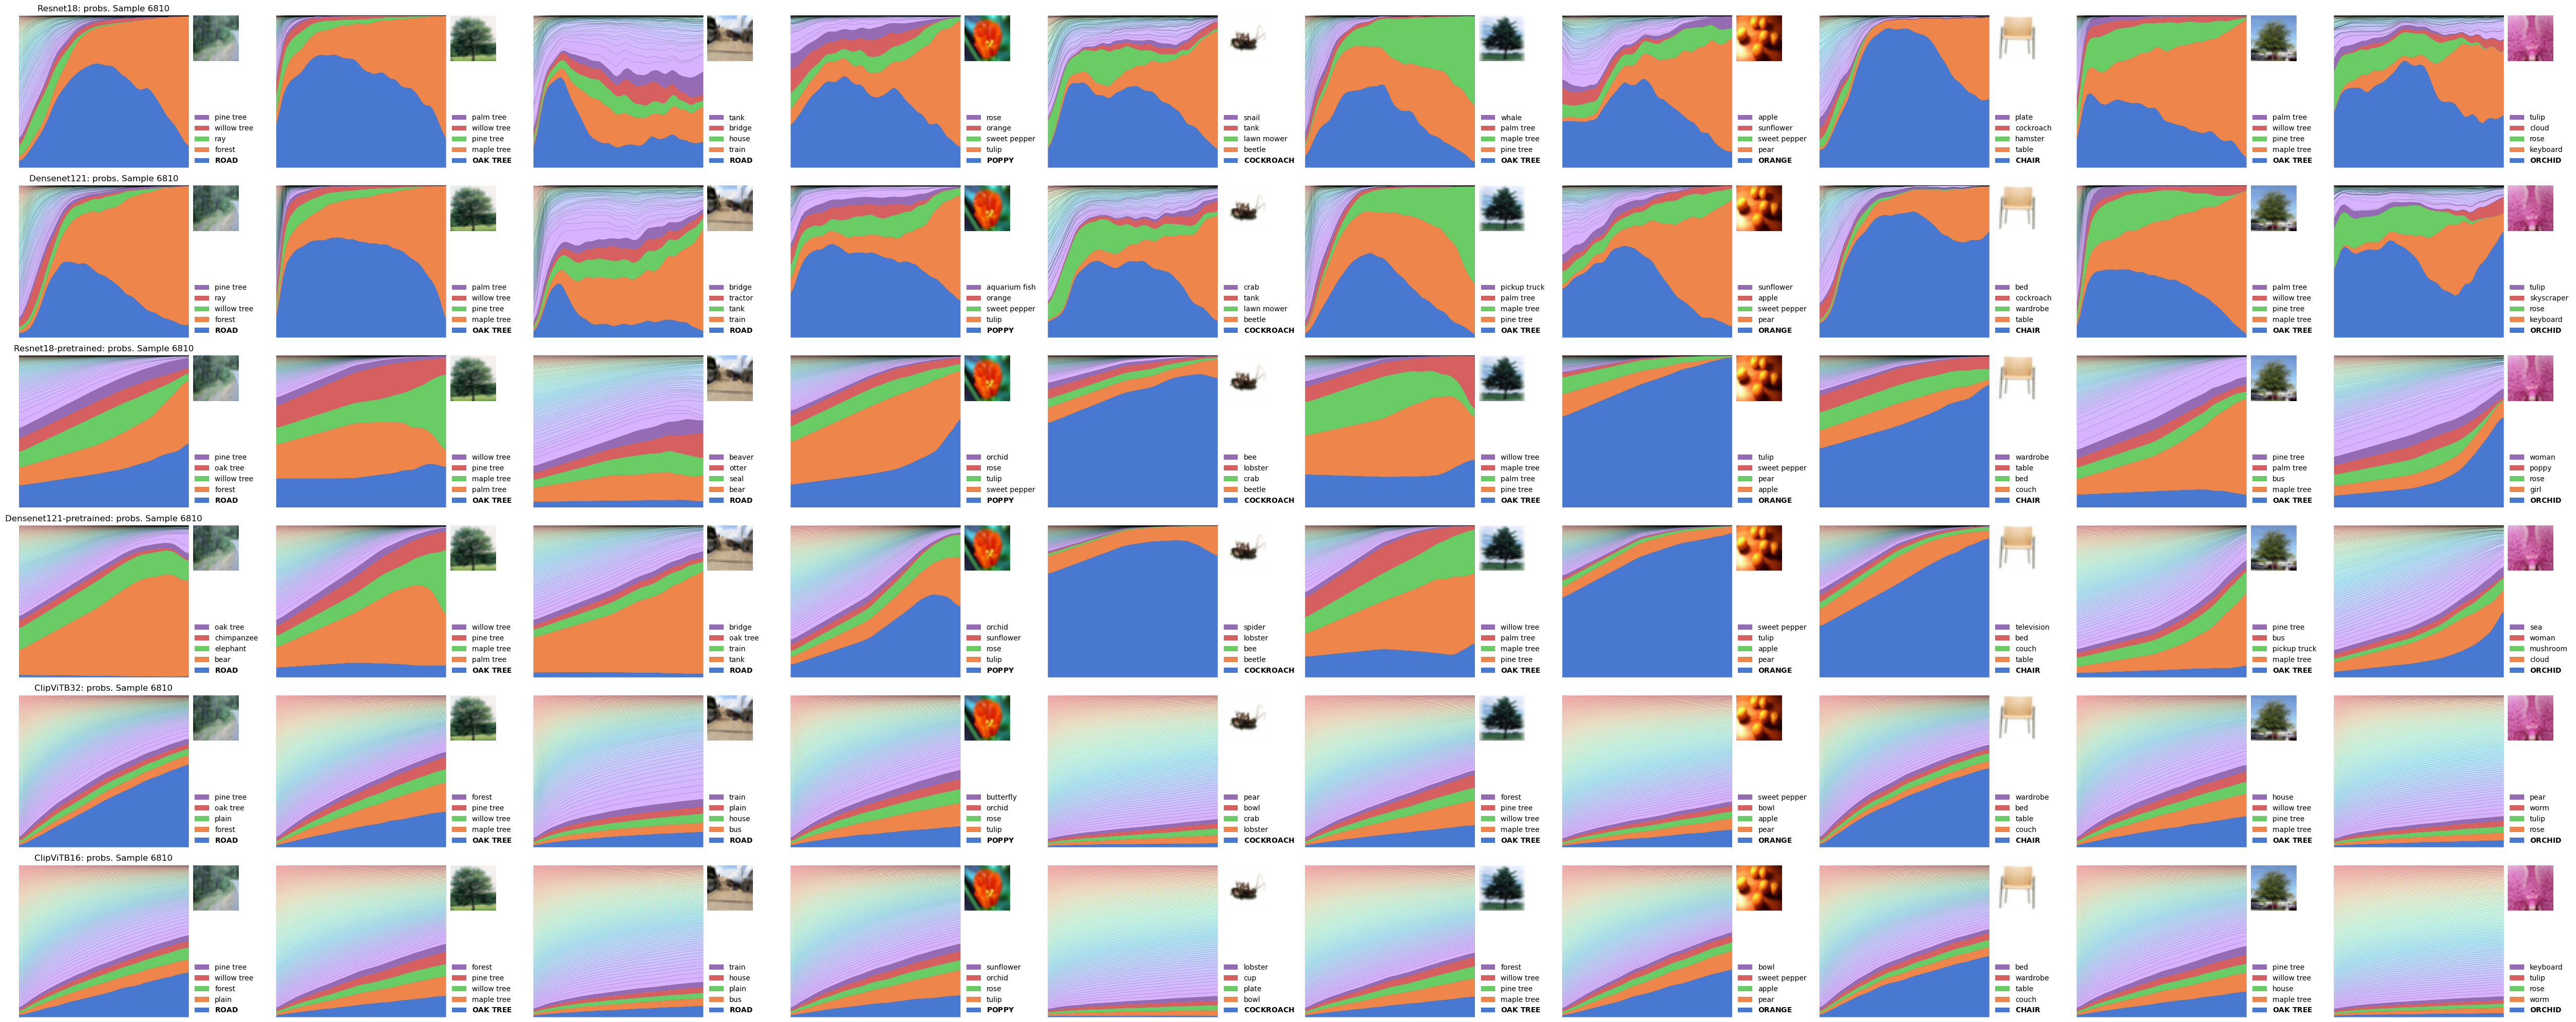

In [9]:
models = ['Resnet18', 'Densenet121', 'Resnet18-pretrained', 'Densenet121-pretrained', 'ClipViTB32', 'ClipViTB16']
t = 'probs'

ncols = 10
sns.reset_defaults()
mpl.rcParams['font.family'] = 'sans-serif'
f, axs = plt.subplots(nrows=len(models), ncols=ncols, figsize = (50, 20))
for c in range(ncols):
    for r in range(len(models)): # each row is a model
        ax = axs[r][c]
        
        m = models[r]
        G = Gs[m]
        xkey = 'x' if t!='probs' else 'xsoft'
        x = G[xkey]
        i=idx[c] # image index

        yy = G[t][i]
        for j in range(len(yy)):
            yy[j] = gaussian_filter1d(yy[j], sigma=1.0)
        
        stacksimple(i, x, yy, ax=ax) # the actual plot
        
        if c == 0:
            ax.set_title(f'{m}: {t}. Sample {i}');

plt.tight_layout()

In [121]:
axs.shape

(6, 10)